<a href="https://colab.research.google.com/github/SihaoCheng/scattering_transform/blob/master/ST_image_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
%matplotlib inline
# import packages
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

import h5py

# mount google drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# import ST module
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import ST

# set default saving directory
save_dir = 'drive/My Drive/Colab Notebooks/'

# Define function of image synthesis

In [3]:
def image_synthesis(image, J, L, num_pixel,
                    learnable_param_list = [(100, 1e-3)],
                    savedir = '',
                    device='cpu',
                    coef = 'ST',
                    random_seed = 987,
                    low_bound = -0.010):

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    image = image[:num_pixel, :num_pixel]
    image_torch = torch.from_numpy(image).type(torch.FloatTensor) + 5
    if device=='gpu':
        image_torch = image_torch.cuda()
    
    target_bi = bispectrum_calculator.forward(image_torch)
    target_ST = ST_calculator.forward(image_torch[None,:,:], J, L)[0][0]
    target_ST = target_ST[target_ST!=0].log()
    target_PS, _ = ST.get_power_spectrum(image_torch, 20, device)
    target_PS = target_PS.log()

#-------------------------------------------------------------------------------
    # define mock image
    class model_image(torch.nn.Module):
        def __init__(self):
            super(model_image, self).__init__()

            # initialize with GRF of same PS as target image
            image_to_train = torch.from_numpy(
                ST.get_random_data(image, num_pixel, num_pixel, "image").reshape(1,-1)*1
            ).type(torch.FloatTensor) + 5 + 0.000
            if device=='gpu':
                image_to_train = image_to_train.cuda()
            self.param = torch.nn.Parameter( image_to_train )
#-------------------------------------------------------------------------------
    model_fit = model_image()

    # define learnable
    for learnable_group in range(len(learnable_param_list)):
        num_step = learnable_param_list[learnable_group][0]
        learning_rate = learnable_param_list[learnable_group][1]
        
        # optimizer = torch.optim.Adam(model_fit.parameters(), lr=learning_rate)
#         optimizer = torch.optim.SGD(model_fit.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adamax(model_fit.parameters(), lr=learning_rate)

        # optimize
        for i in range(int(num_step)):
            # loss: power spectrum
            PS, _ = ST.get_power_spectrum(model_fit.param.reshape(num_pixel,num_pixel), 20, device)
            PS = PS.log()
            loss_PS = ((target_PS - PS)**2).sum()
            # loss: L1
            target_L1 = (image_torch-5).abs().mean() 
            loss_L1 = (
                ((model_fit.param-5).abs().mean() - target_L1) / target_L1 
            )**2*1e6
            # loss: mean
            loss_mean = (
                model_fit.param.reshape(1,num_pixel,num_pixel).mean() - 
                image_torch.mean()
            )**2*1e7
            # loss: bound
            loss_bound = torch.exp(
                (5 + low_bound - model_fit.param.reshape(1,num_pixel,num_pixel))/0.003
            ).mean()

            if coef=='bi':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1

            if coef=='bi+P':
                bi = bispectrum_calculator.forward(
                    model_fit.param.reshape(num_pixel,num_pixel)
                )
                loss_bi = ((target_bi - bi)**2).sum()
                loss = loss_bi + loss_bound + loss_mean + loss_L1 + loss_PS
                
            elif coef=='ST':
                ST_coef = ST_calculator.forward(
                    model_fit.param.reshape(1,num_pixel,num_pixel), J, L,
                  )[0][0]
                ST_coef = ST_coef[ST_coef!=0].log()
                loss_ST = ((target_ST - ST_coef)**2).sum()*1000
                loss = loss_ST + loss_bound + loss_mean + loss_L1
            else:
                loss = loss_bound + loss_mean + loss_L1
                
            if i%100== 0:
                # save map
                # np.save(savedir + 'synthesis_results_step=' + str(i) + '.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                # np.save(savedir +'synthesis_results_final.npy', 
                #         model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5)
                print(i)
                print('loss: ',loss)
                print('loss_mean: ',loss_mean)
                print('loss_bound: ',loss_bound)
                print('loss_L1: ',loss_L1)
                if coef=='bi' or coef=='bi+P':
                    print('loss_bi: ',loss_bi)
                if coef=='bi+P':
                    print('loss_PS: ',loss_PS)
                if coef=='ST':
                    print('loss_ST: ',loss_ST)

            optimizer.zero_grad();
            loss.backward();
            optimizer.step();

    return model_fit.param.reshape(1,num_pixel,num_pixel).cpu().detach().numpy()-5

# Load data & Create calculators

# Load target image

In [7]:
viirs_allclear = '/home/xavier/Projects/Oceanography/SST/VIIRS/PreProc/VIIRS_all_100clear_preproc.h5'
viirs = h5py.File(viirs_allclear, 'r')
viirs['valid'].shape
#
image = viirs['valid'][1010,0,...]

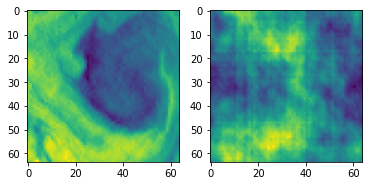

In [10]:
# load target image

#save_dir = 'drive/My Drive/Colab Notebooks/'
save_dir = '/home/xavier/Projects/Oceanography/ST/'

M = 64
N = M
#image = np.load('drive/My Drive/Colab Notebooks/H51_9.npy')[:M,:N]


plt.subplot(121)
plt.imshow(image)#, vmin=-0.03, vmax=0.1)
plt.subplot(122)
np.random.seed(989)
plt.imshow(ST.get_random_data(image, M, N, mode='image'))#, vmin=-0.04, vmax=0.1)
plt.show()

# CPU / GPU

In [12]:
#device = 'gpu'
device = 'cpu'

# Generate wavelet filter bank

In [13]:
J = 7
L = 8
filters_set = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_morlet(
    if_save=False, save_dir=None, precision='single'
)

# Create an ST calculator

In [16]:
reload(ST)
ST_calculator = ST.ST_2D(filters_set, J, L, device=device)
image_torch = torch.from_numpy(image)[None,:,:]
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(2) 
start = time.time()
S = ST_calculator.forward(image_torch, J, L)[0]
print('% .4f s' % (time.time() - start))

 0.0488 s


# Create a bispectrum calculator 

In [17]:
bin_edges = np.linspace(150/(360/3.5), M/2*1.4, 7) # in unit of pixel in Fourier space

bispectrum_calculator = ST.Bispectrum_Calculator(bin_edges, M, N, device=device)
image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

torch.set_num_threads(1) 
start = time.time()
B = bispectrum_calculator.forward(image_torch)
print('% .4f s' % (time.time() - start))

 0.0061 s


In [18]:
B[:10]

tensor([[-1.8100e+04, -1.0074e+03, -3.0424e+02, -2.4701e+02,  4.4714e+02,
         -4.5163e+01, -5.7159e+00, -9.7017e+00,  6.1572e+01,  2.4691e+02,
         -1.0540e+02,  3.5884e+01,  8.3437e+00, -2.1334e+01, -1.2020e-02,
         -2.2142e+01, -7.3099e+00, -6.4373e+01, -3.1478e+01, -1.8993e+01,
         -1.0383e+01,  8.7807e+00, -4.7717e+00, -1.3263e+01, -6.7219e+00,
          5.4765e+00, -4.0062e-02, -2.1820e+00,  9.2100e+00, -8.3058e+00,
          9.0936e-01, -4.9271e-02,  3.5527e-07, -1.9429e-08],
        [-1.8100e+04, -1.0074e+03, -3.0424e+02, -2.4701e+02,  4.4714e+02,
         -4.5163e+01, -5.7159e+00, -9.7017e+00,  6.1572e+01,  2.4691e+02,
         -1.0540e+02,  3.5884e+01,  8.3437e+00, -2.1334e+01, -1.2020e-02,
         -2.2142e+01, -7.3099e+00, -6.4373e+01, -3.1478e+01, -1.8993e+01,
         -1.0383e+01,  8.7807e+00, -4.7717e+00, -1.3263e+01, -6.7219e+00,
          5.4765e+00, -4.0062e-02, -2.1820e+00,  9.2100e+00, -8.3058e+00,
          9.0936e-01, -4.9271e-02,  3.5527e-07, -1

# Test the power spectrum function

In [19]:
bins = 20
#device = 'gpu'
device = 'cpu'

image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

ST.get_power_spectrum(image_torch, bins, device)

(tensor([2.2221e-03, 4.4683e+02, 2.0666e+02,        nan, 1.7210e+02, 7.4293e+01,
         5.7879e+01, 5.4817e+01, 2.8260e+01, 2.7845e+01, 1.7902e+01, 1.2234e+01,
         8.3220e+00, 6.0986e+00, 4.1609e+00, 3.1781e+00, 2.3716e+00, 1.9650e+00,
         1.5229e+00, 1.3527e+00]),
 tensor([ 0.0000,  1.0000,  1.2215,  1.4922,  1.8228,  2.2266,  2.7199,  3.3224,
          4.0585,  4.9576,  6.0560,  7.3976,  9.0366, 11.0386, 13.4841, 16.4714,
         20.1206, 24.5782, 30.0234, 36.6749, 44.8000]))

# Run synthesis & Show result

In [ ]:
# synthesis

coef = 'ST'#'bi+P'
#device = 'gpu'
device = 'cpu'

for random_seed in [987]:
    synthesised_image = image_synthesis(
        image, J=J, L=L, num_pixel=M,
        learnable_param_list = [
            (100*2, 5e-3), (100*2, 1e-3), (100*1, 1e-3),
            (100*1, 5e-4), (100*1, 2e-4), (100*1, 1e-4),
        ],
        savedir = save_dir,
        device = device,
        coef = coef,
        random_seed = random_seed,
        low_bound = -0.015,#-0.010,
    )
    # np.save(save_dir +'synthesis_results_final.npy', synthesised_image)
    
    synthesised_image = synthesised_image[0]
    plt.figure(figsize=(12,3),dpi=200)
    plt.subplot(141)
    plt.imshow(image, vmin=-0.04, vmax=0.10, )
    plt.title('target image')
    plt.xticks([]); plt.yticks([])

    plt.subplot(142)
    plt.imshow(synthesised_image, 
               vmin=-0.04, vmax=0.10, )
    plt.title('synthesized image (bi)')
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(143)
    y, x = np.histogram(image,  100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='target')
    y, x = np.histogram(synthesised_image,
                        100, (-0.2,0.5))
    plt.plot((x[1:]+x[:-1])/2, y, label='synthesized')
    plt.legend()
    plt.yscale('log')
    plt.show()
    print(image.std(),  synthesised_image.std())

0
loss:  tensor(inf, grad_fn=<AddBackward0>)
loss_mean:  tensor(2.2737e-06, grad_fn=<MulBackward0>)
loss_bound:  tensor(inf, grad_fn=<MeanBackward0>)
loss_L1:  tensor(7784.9917, grad_fn=<MulBackward0>)
loss_ST:  tensor(62563.5273, grad_fn=<MulBackward0>)


/home/xavier/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
